# 고양이, 개 분류 - CNN v2
- Dropout 추가

In [1]:
import cv2
import matplotlib.pyplot as plt


In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-01-18 02:24:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  22.5MB/s    in 2.9s    

2022-01-18 02:24:23 (22.5 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
!unzip cats_and_dogs_filtered.zip > /dev/null

* 데이터 탐색

In [4]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [5]:
# 파일 이름
import os
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])


['cat.976.jpg', 'cat.230.jpg', 'cat.493.jpg', 'cat.626.jpg', 'cat.186.jpg']
['dog.362.jpg', 'dog.98.jpg', 'dog.667.jpg', 'dog.766.jpg', 'dog.332.jpg']


In [6]:
# 파일 갯수
len(train_cats_fnames), len(train_dogs_fnames)

(1000, 1000)

* 모델 구성

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [8]:
model = Sequential([
    Conv2D(16, kernel_size=(3,3), input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)        0

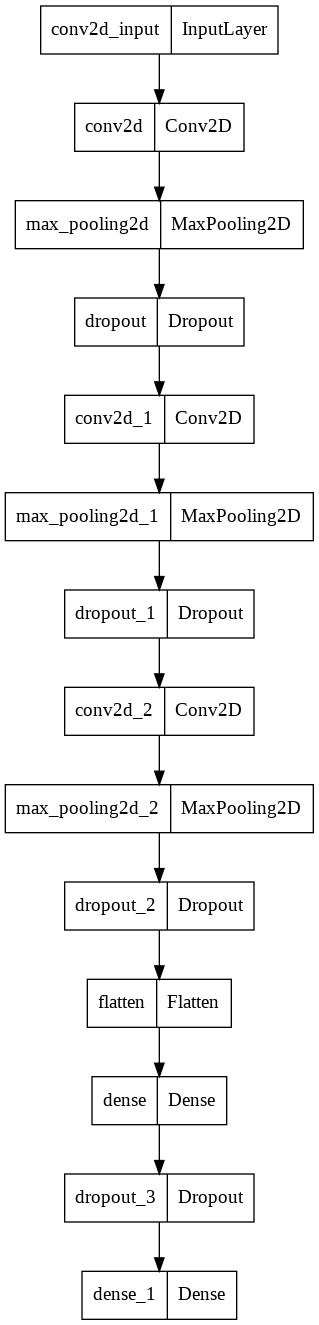

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model)

* 모델 설정

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

- 파일에서 이미지 데이터 읽어오는 방법

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
train_dir

'cats_and_dogs_filtered/train'

* callback 정의

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'best-cat-dog-v2.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

- 모델 실행

In [15]:
hist = model.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs=100, 
    steps_per_epoch=100,           # 한 번의 epoch에서 훈련에 사용할 batch의 갯수
    validation_steps=50,            # 한 번의 epoch가 끝났을 때, 테스트에 사용되는 batch에 갯수
    verbose=2, 
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.69232, saving model to best-cat-dog-v2.h5
100/100 - 23s - loss: 0.9980 - accuracy: 0.4955 - val_loss: 0.6923 - val_accuracy: 0.5440 - 23s/epoch - 232ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 0.69232 to 0.67361, saving model to best-cat-dog-v2.h5
100/100 - 11s - loss: 0.6947 - accuracy: 0.5575 - val_loss: 0.6736 - val_accuracy: 0.6130 - 11s/epoch - 106ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 0.67361 to 0.65298, saving model to best-cat-dog-v2.h5
100/100 - 11s - loss: 0.6627 - accuracy: 0.6195 - val_loss: 0.6530 - val_accuracy: 0.6480 - 11s/epoch - 106ms/step
Epoch 4/100

Epoch 00004: val_loss improved from 0.65298 to 0.64362, saving model to best-cat-dog-v2.h5
100/100 - 10s - loss: 0.6248 - accuracy: 0.6660 - val_loss: 0.6436 - val_accuracy: 0.6640 - 10s/epoch - 104ms/step
Epoch 5/100

Epoch 00005: val_loss improved from 0.64362 to 0.60718, saving model to best-cat-dog-v2.h5
100/100 - 10s - loss: 0.

In [16]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)

- 테스트 이미지 분류

In [22]:
from google.colab import files

up = files.upload()

Saving cat1.jfif to cat1.jfif
Saving cat2.jfif to cat2.jfif
Saving cat3.jfif to cat3.jfif
Saving cat4.jfif to cat4.jfif
Saving dog1.jfif to dog1.jfif
Saving dog2.jfif to dog2.jfif
Saving dog3.jfif to dog3.jfif
Saving dog4.jfif to dog4.jfif
Saving dog5.jfif to dog5.jfif


In [23]:
for fname in up.keys():
    img = cv2.imread(fname)[:,:,::-1]
    if sum(img.shape[:-1]) > 300: # 150 x 150 보다 큰 이미지
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
    else:
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_CUBIC)
    classes = best_model.predict(img.reshape(1,150,150,3))
    print(f"{classes[0,0]} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

0.0 cat1.jfif is a cat
6.011830464558443e-06 cat2.jfif is a cat
0.0 cat3.jfif is a cat
0.0 cat4.jfif is a cat
1.0 dog1.jfif is a dog
1.0 dog2.jfif is a dog
1.0 dog3.jfif is a dog
1.0 dog4.jfif is a dog
0.0 dog5.jfif is a cat


* 학습과정 시각화

In [24]:
import numpy as np
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

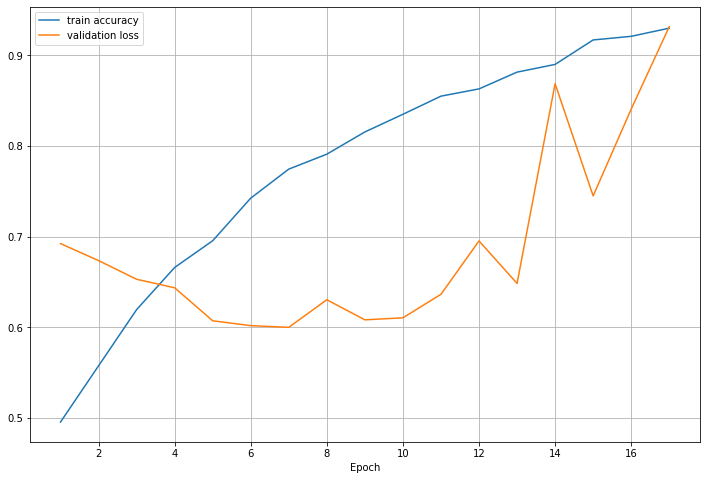

In [25]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.show()